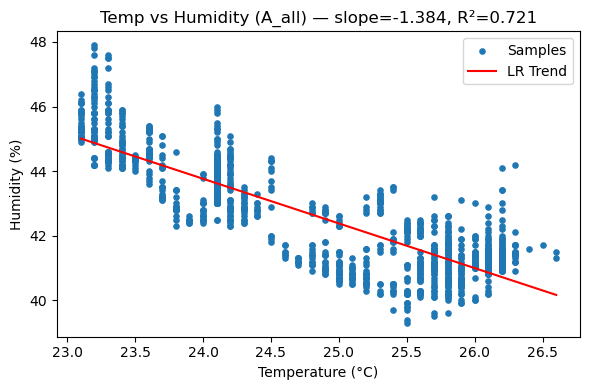

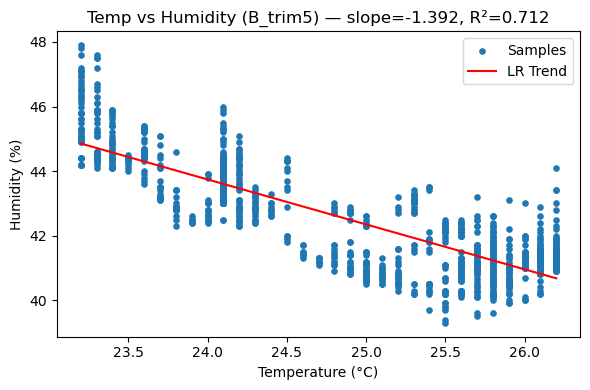

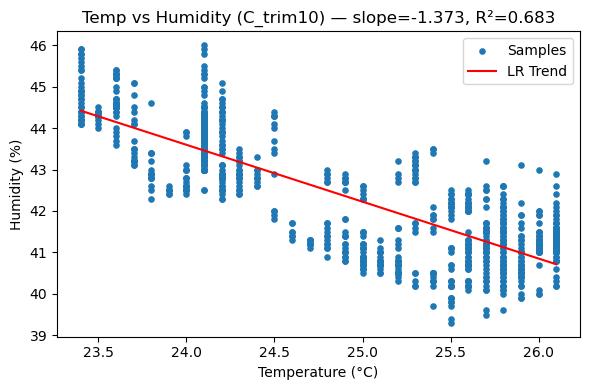


Summary Table:
    Scenario     Slope        R²  Samples                             Plot Path
0  All data -1.384173  0.721385     1441     week-7-outputs/scenario_A_all.png
1   Trim 5% -1.391847  0.711952     1387   week-7-outputs/scenario_B_trim5.png
2  Trim 10% -1.372751  0.682720     1183  week-7-outputs/scenario_C_trim10.png

Saved plots and summary in: /Users/adityasuhag/SIT225_2024T2/week 7 content /week-7-outputs


In [7]:
# SIT225 Week 7 – Linear Regression on DHT22 Data


RUN_LOGGER = False
SERIAL_PORT = "/dev/cu.usbmodem1101"
BAUD_RATE = 115200
CSV_PATH = "dht22_log.csv"
OUTDIR_NAME = "week-7-outputs"
LOG_LINES_TO_READ = None  # None = keep logging until stopped

import time, csv, datetime
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

if RUN_LOGGER:
    import serial
    from serial.tools import list_ports

OUTDIR = Path(OUTDIR_NAME)
OUTDIR.mkdir(parents=True, exist_ok=True)

def log_data(port, baud, csv_path, lines_to_read=None, delay=2):
    csv_path = Path(csv_path)
    is_new = not csv_path.exists()
    ser = serial.Serial(port, baud, timeout=3)
    time.sleep(1)
    ser.reset_input_buffer()
    with csv_path.open("a", newline="") as f:
        writer = csv.writer(f)
        if is_new:
            writer.writerow(["timestamp_iso", "temperature_c", "humidity_pct"])
        count = 0
        try:
            while True:
                raw = ser.readline().decode("utf-8", errors="ignore").strip()
                if not raw or raw.startswith("#"):
                    continue
                try:
                    t, h = [float(x.strip()) for x in raw.split(",")]
                except:
                    continue
                now = datetime.datetime.now().isoformat(timespec="seconds")
                writer.writerow([now, t, h])
                f.flush()
                print(f"{now} -> T={t:.2f}°C, H={h:.2f}%")
                count += 1
                if lines_to_read and count >= lines_to_read:
                    break
                time.sleep(delay)
        except KeyboardInterrupt:
            pass
        finally:
            ser.close()
            print(f"Saved CSV at {csv_path.resolve()}")

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.rename(columns={c: c.strip().lower() for c in df.columns})
    df["temperature_c"] = pd.to_numeric(df["temperature_c"], errors="coerce")
    df["humidity_pct"] = pd.to_numeric(df["humidity_pct"], errors="coerce")
    df = df.dropna(subset=["temperature_c", "humidity_pct"]).copy()
    if "timestamp_iso" in df.columns:
        df["timestamp_iso"] = pd.to_datetime(df["timestamp_iso"], errors="coerce")
        df = df.sort_values("timestamp_iso")
    return df

def fit_and_plot(df, tag):
    X = df[["temperature_c"]].values
    y = df["humidity_pct"].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = float(model.coef_[0])
    t_min, t_max = df["temperature_c"].min(), df["temperature_c"].max()
    t_grid = np.linspace(t_min, t_max, 100).reshape(-1, 1)
    y_pred = model.predict(t_grid)
    path = OUTDIR / f"scenario_{tag}.png"
    plt.figure(figsize=(6, 4))
    plt.scatter(df["temperature_c"], df["humidity_pct"], s=14, label="Samples")
    plt.plot(t_grid, y_pred, color="red", label="LR Trend")
    plt.title(f"Temp vs Humidity ({tag}) — slope={slope:.3f}, R²={r2:.3f}")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Humidity (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=240)
    plt.show()
    return slope, r2, len(df), path

def main():
    if RUN_LOGGER:
        log_data(SERIAL_PORT, BAUD_RATE, CSV_PATH, LOG_LINES_TO_READ)
    if not Path(CSV_PATH).exists():
        print("No CSV found. Please enable logging or add a file.")
        return
    df = load_data(CSV_PATH)
    if len(df) < 2:
        print("Not enough data points.")
        return

    sA, rA, nA, pA = fit_and_plot(df, "A_all")
    low, high = df["temperature_c"].quantile(0.05), df["temperature_c"].quantile(0.95)
    dfB = df[(df["temperature_c"] >= low) & (df["temperature_c"] <= high)]
    sB, rB, nB, pB = fit_and_plot(dfB, "B_trim5")
    low2, high2 = df["temperature_c"].quantile(0.10), df["temperature_c"].quantile(0.90)
    dfC = df[(df["temperature_c"] >= low2) & (df["temperature_c"] <= high2)]
    sC, rC, nC, pC = fit_and_plot(dfC, "C_trim10")

    summary = pd.DataFrame([
        ["All data", sA, rA, nA, str(pA)],
        ["Trim 5%", sB, rB, nB, str(pB)],
        ["Trim 10%", sC, rC, nC, str(pC)]
    ], columns=["Scenario", "Slope", "R²", "Samples", "Plot Path"])
    summary_path = OUTDIR / "lr_summary.csv"
    summary.to_csv(summary_path, index=False)
    print("\nSummary Table:\n", summary)
    print(f"\nSaved plots and summary in: {OUTDIR.resolve()}")

if __name__ == "__main__":
    main()


